Imports and Path Setup

In [13]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Project paths (relative to notebook location)
PROJECT_ROOT = Path.cwd().parent  # Goes up one level from notebooks/
DATA_DIR = PROJECT_ROOT / "data"
TRAIN_IMG_DIR = DATA_DIR / "train"

Data Loading

In [18]:
def load_data():
    """Load and parse all dataset files"""
    # Read raw files
    train_df = pd.read_csv(DATA_DIR / "train.csv")
    unicode_map = pd.read_csv(DATA_DIR / "unicode_translation.csv")
    
    # Parse packed labels into individual characters
    def parse_labels(label_str):
        parts = label_str.split()
        return [{
            'unicode': parts[i],
            'x_min': int(parts[i+1]),
            'y_min': int(parts[i+2]),
            'width': int(parts[i+3]),
            'height': int(parts[i+4])
        } for i in range(0, len(parts), 5)]
    
    # Convert to one row per character
    train_df['characters'] = train_df['labels'].apply(parse_labels)
    train_df = train_df.explode('characters').reset_index(drop=True)
    train_df = pd.concat([train_df.drop(['characters', 'labels'], axis=1), 
                         train_df['characters'].apply(pd.Series)], axis=1)
    
    print(train_df.columns)
    
    # Merge with Unicode mappings
    train_df = train_df.merge(unicode_map, on='unicode', how='left')
    
    return train_df

# Load all data
train_df = load_data()
print(f"Loaded {len(train_df)} character annotations")
print(train_df.head(3))

Index(['image_id', 'unicode', 'x_min', 'y_min', 'width', 'height'], dtype='object')
Loaded 683464 character annotations
            image_id unicode  x_min  y_min  width  height char
0  100241706_00004_2  U+306F   1231   3465    133      53    は
1  100241706_00004_2  U+304C    275   1652     84      69    が
2  100241706_00004_2  U+3044   1495   1218    143      69    い


Visualization

c:\Users\TIBI\.conda\envs\IAVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12399 (\N{HIRAGANA LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\TIBI\.conda\envs\IAVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12364 (\N{HIRAGANA LETTER GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\TIBI\.conda\envs\IAVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12356 (\N{HIRAGANA LETTER I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\TIBI\.conda\envs\IAVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12369 (\N{HIRAGANA LETTER KE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\TIBI\.conda\envs\IAVA\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  fig.ca

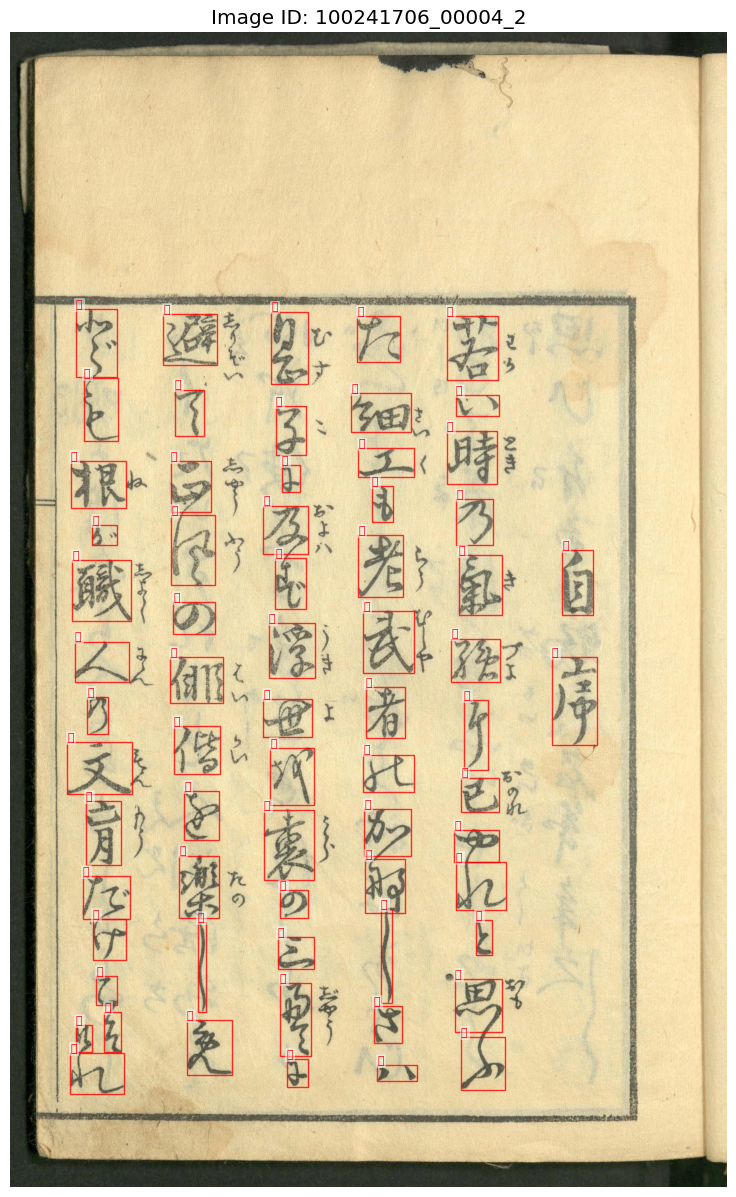

In [19]:
def plot_image_with_boxes(image_id, figsize=(15, 15)):
    """Display image with annotated character boxes"""
    img_path = TRAIN_IMG_DIR / f"{image_id}.jpg"
    if not img_path.exists():
        print(f"Image not found: {img_path}")
        return
    
    # Load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get annotations
    annotations = train_df[train_df['image_id'] == image_id]
    
    # Plot
    plt.figure(figsize=figsize)
    plt.imshow(img)
    ax = plt.gca()
    
    for _, row in annotations.iterrows():
        # Draw bounding box
        rect = plt.Rectangle(
            (row['x_min'], row['y_min']),
            row['width'], row['height'],
            fill=False, color='red', linewidth=1, alpha=0.8
        )
        ax.add_patch(rect)
        
        # Add character label
        ax.text(
            row['x_min'], row['y_min'] - 5,
            row['char'],
            fontsize=8, color='red',
            bbox=dict(facecolor='white', alpha=0.5, pad=1)
        )
    
    plt.axis('off')
    plt.title(f"Image ID: {image_id}")
    plt.show()

# Example usage
plot_image_with_boxes("100241706_00004_2")

Dataset Analysis

In [20]:
def analyze_dataset(df):
    """Generate key statistics about the dataset"""
    stats = {
        'total_images': df['image_id'].nunique(),
        'total_characters': len(df),
        'unique_characters': df['unicode'].nunique(),
        'chars_per_image': len(df) / df['image_id'].nunique(),
        'top_characters': df['char'].value_counts().head(10)
    }
    
    # Image dimensions analysis
    sample_img = cv2.imread(str(TRAIN_IMG_DIR / f"{df['image_id'].iloc[0]}.jpg"))
    stats['image_shape'] = sample_img.shape
    
    return stats

# Run analysis
dataset_stats = analyze_dataset(train_df)
print("\nDataset Statistics:")
for k, v in dataset_stats.items():
    print(f"- {k}: {v}")


Dataset Statistics:
- total_images: 3605
- total_characters: 683464
- unique_characters: 4212
- chars_per_image: 189.5877947295423
- top_characters: char
に    24685
の    24136
し    22209
て    20569
と    16588
を    15743
は    14759
か    14342
り    14184
な    13750
Name: count, dtype: int64
- image_shape: (3874, 2404, 3)
